In [35]:
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from collections import deque
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

In [36]:
from sklearn.datasets import load_svmlight_file

In [37]:
x_train, y_train = load_svmlight_file("./Regression dataset/reg.train.txt")
x_train = x_train.toarray()
print("train_x size {}, train_y size {}".format(x_train.shape, y_train.shape))

x_test, y_test = load_svmlight_file("./Regression dataset/reg.test.txt")
x_test = x_test.toarray()
print("test_x size {}, test_y size {}".format(x_test.shape, y_test.shape))

train_x size (7200, 245), train_y size (7200,)
test_x size (10050, 245), test_y size (10050,)


In [38]:
x_train_bst, x_train_lin, y_train_bst, y_train_lin = train_test_split(x_train, y_train, test_size = 0.2)

In [39]:
x_train_bst[0][:20]

array([0.      , 0.      , 0.      , 0.      , 0.020218, 0.      ,
       0.655606, 0.54098 , 0.16042 , 0.      , 0.709939, 0.      ,
       0.73771 , 0.011765, 0.513726, 0.875   , 1.      , 0.988235,
       0.      , 0.      ])

In [40]:
y_train_bst[:20]

array([2. , 0.5, 2. , 2. , 2. , 2. , 3. , 1. , 0. , 2. , 2. , 2. , 1. ,
       1. , 0. , 0. , 2. , 0. , 1. , 1. ])

In [97]:
class MyDecisionTreeRegressor:
    NON_LEAF = 'NON_LEAF'
    LEAF = 'LEAF'

    def __init__(self,
                 min_samples_split=3,
                 max_depth=3,
                 min_impurity=0.1, recursion = True,
                 max_log = False):

        self.tree = dict()
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.min_impurity = min_impurity
        self.recursion = recursion
        self.leafctr = 0
        self.leaves = dict()
        self.max_log = max_log
        
    @staticmethod
    def divide_items_(x, y, feat, thr):
        left_mask = x[:, feat] > thr
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]

    def variance_(self,y):
        n = y.shape[1]
        ysq = y ** 2
        sum_sl = (ysq[:, :n - 1]).cumsum(1)
        sum_sr = ysq.sum(1)[:, None] - sum_sl
        mean_sl = sum_sl / np.arange(1, n)
        mean_sr = sum_sr / (n - np.arange(1, n))
        sum_l = (y[:, :n - 1]).cumsum(1)
        sum_r = y.sum(1)[:, None] - sum_l
        mean_l = sum_l / np.arange(1, n)
        mean_r = sum_r / (n - np.arange(1, n))
        std_l = mean_sl - mean_l ** 2
        std_r = mean_sr - mean_r ** 2
        return std_l * (np.arange(1, n) / n) + std_r * ((n - np.arange(1, n)) / n)

    def get_b_idx(self, x):
        ind = np.argwhere(np.abs(np.diff(x, axis=0).T) > 1e-27)
        b_idx = []
        for i in range(x.shape[1]):
            to_app = ind[ind[:, 0] == i][:, 1]
            if to_app.shape[0] == 0:
                to_app = np.array([float('+inf')])
            b_idx.append(to_app)
        return b_idx
    def get_log_n_featutes(self, x):
        defids = np.arange(x.shape[1])
        np.random.shuffle(defids)
        logn = int(np.log(x.shape[1]))
        fids = np.random.choice(defids, logn)
        return fids
    
    def threshold(self, x, y, fids):
        idxsorted = np.argsort(x[:,fids], axis=0)
        xsorted, ysorted = x[idxsorted, fids], y[idxsorted]
        if len(ysorted.shape) == 1:
            ysorted = ysorted[None, :]
        if len(xsorted.shape) == 1:
            xsorted = xsorted[None, :]
        b_idxes = self.get_b_idx(xsorted)
        variance = self.variance_(ysorted.T)
        var_idx = []
        var_no_idx = []
        for f_idx, b_idx in enumerate(b_idxes):
            if b_idx[0] == float('+inf'):
                var_idx.append(0)
                var_no_idx.append(f_idx)
                continue
            idx = np.argmin(variance[f_idx, b_idx])
            var_idx.append(b_idx[idx])
        var_idx = np.array(var_idx)
        var_no_idx = np.array(var_no_idx)
        min_variance = variance[np.arange(variance.shape[0]), var_idx.ravel()]
        if var_no_idx.shape[0] > 0:
            min_variance[var_no_idx] = float('+inf')
        min_variance[var_idx + 1 <= self.min_samples_split] = np.float('+inf')
        min_variance[var_idx + 1 >= ysorted.shape[0] - self.min_samples_split] = np.float('+inf')
        thr = np.mean([xsorted[var_idx, np.arange(xsorted.shape[1])],
                          xsorted[var_idx + 1, np.arange(xsorted.shape[1])]], axis = 0)        
        return min_variance, thr

    def is_leaf_(self, x, y, depth):
        return x.shape[0] < 2 * self.min_samples_split + 2 or np.unique(y).shape[0] == 1 or \
               self.max_depth is not None and depth >= self.max_depth or \
            self.min_impurity is not None and \
                        np.mean((y - y.mean()) ** 2) < self.min_impurity
    def fit(self, x, y):
        if self.recursion:
            self.fit_node_(x, y, 0, 0)
        else:
            self.fit_no_rec_( x, y)
        return self

 
    def fit_no_rec_(self, x, y):
        depth = 0
        dq = deque()
        dq.append([x, y, 0])
        while depth < self.max_depth and len(dq) != 0:
            toretrieve = len(dq)
            while toretrieve != 0 and len(dq) > 0:
                unit = dq.pop()
                if self.is_leaf_(unit[0], unit[1], depth):
                    self.tree[unit[2]]= (self.LEAF, unit[1].mean())
                    self.leaves[unit[2]] = self.leafctr
                    self.leafctr += 1
                    continue
                if self.max_log:
                    fids = self.get_log_n_featutes(unit[0])
                else:
                    fids = np.arange(unit[0].shape[1])
                np.random.shuffle(fids)
                var, thrs = self.threshold(unit[0], unit[1], fids)
                best_var_idx = np.argmin(var)
                best_var = var[best_var_idx]
                best_thr = thrs[best_var_idx]
                best_feat = fids[best_var_idx]
                if best_var == float('+inf'):
                    self.tree[unit[2]] = (self.LEAF,unit[1].mean())
                    self.leaves[unit[2]] = self.leafctr
                    self.leafctr += 1
                    continue
                left_x, right_x, left_y, right_y = self.divide_items_(unit[0], unit[1], best_feat, best_thr)
                if left_x.shape[0] == 0 or right_x.shape[0] == 0:
                    self.tree[unit[2]] = (self.LEAF,unit[1].mean())
                    self.leaves[unit[2]] = self.leafctr
                    self.leafctr += 1
                    continue
                self.tree[unit[2]] = (self.NON_LEAF, best_feat, best_thr, unit[1].mean())
                dq.appendleft([left_x,left_y, 2 * unit[2] + 1])
                dq.appendleft([right_x, right_y, 2 * unit[2] + 2])
                toretrieve-=1
            depth += 1
        return
        
    def fit_node_(self, x, y, node_id, depth):
        if self.is_leaf_(x, y, depth):
            self.tree[node_id] = (self.LEAF,y.mean())
            self.leaves[node_id] = self.leafctr
            self.leafctr += 1
            return
        if self.max_log:
            fids = self.get_log_n_featutes(x)
        else:
            fids = np.arange(x.shape[1])
        np.random.shuffle(fids)
        var, thrs = self.threshold(x, y, fids)
        best_var_idx = np.argmin(var)
        best_var = var[best_var_idx]
        best_thr = thrs[best_var_idx]
        best_feat = fids[best_var_idx]
        if best_var == float('+inf'):
            self.tree[node_id] = (self.LEAF,y.mean())
            self.leaves[node_id] = self.leafctr
            self.leafctr += 1
            return
        left_x, right_x, left_y, right_y = self.divide_items_(x, y, best_feat, best_thr)
        if left_x.shape[0] == 0 or right_x.shape[0] == 0:
            self.tree[node_id] = (self.LEAF,y.mean())
            self.leaves[node_id] = self.leafctr
            self.leafctr += 1
            return
        self.tree[node_id] = (self.NON_LEAF, best_feat, best_thr, y.mean())
        self.fit_node_(left_x, left_y, 2 * node_id + 1, depth + 1)
        self.fit_node_(right_x, right_y, 2 * node_id + 2, depth + 1)
        return
    def predict(self, x, forlinear = False):
        return np.array([self.predict_value_(x, 0, forlinear) for x in x])

    def predict_value_(self, x, node_id, forlinear=False):
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF:
            if x[node[1]] > node[2]:
                return self.predict_value_(x, 2 * node_id + 1, forlinear)
            else:
                return self.predict_value_(x, 2 * node_id + 2, forlinear)
        else:
            if forlinear:
                return node[1], node_id
            else: 
                return node[1]

In [98]:
%%time
tree = MyDecisionTreeRegressor(max_log = False)
tree.fit(x_train_bst, y_train_bst)
prd = tree.predict(x_test, forlinear = True)
mse = mean_squared_error(y_test, prd[:,0])
print(tree.tree)
mse

{0: ('NON_LEAF', 225, 0.014134500000000001, 1.0375999276041665), 1: ('NON_LEAF', 42, 0.0012850000000000001, 1.539979479768786), 3: ('NON_LEAF', 9, 0.33784250000000005, 1.792280415800416), 7: ('LEAF', 2.664926551724138), 8: ('LEAF', 1.7362920575221241), 4: ('NON_LEAF', 139, 0.009232, 1.2239462760416668), 9: ('LEAF', 1.4922553703703705), 10: ('LEAF', 1.0281531531531531), 2: ('NON_LEAF', 10, 0.47704349999999995, 0.8219382339950372), 5: ('NON_LEAF', 190, 0.091901, 0.935831603386519), 11: ('LEAF', 1.4154088377358491), 12: ('LEAF', 0.890540096935139), 6: ('NON_LEAF', 161, 0.2723325, 0.4572181741397289), 13: ('LEAF', 0.64801588), 14: ('LEAF', 0.34756432019704436)}
CPU times: user 2.71 s, sys: 143 ms, total: 2.85 s
Wall time: 797 ms


0.8780913310948587

In [43]:
tree.leaves

{3: 0, 4: 1, 5: 2, 6: 3}

In [44]:
%%time
stree = DecisionTreeRegressor(min_samples_split=3, max_depth=3)
stree.fit(x_train_bst, y_train_bst)
mse = mean_squared_error(y_test, stree.predict(x_test))
mse


CPU times: user 134 ms, sys: 48 µs, total: 134 ms
Wall time: 132 ms


0.8782861182792046

In [143]:
class MyMeanEstimator:
    def __init():
        pass

    def fit(self, X, y):
        self.leaves = {}
        self.tmp = np.mean(y)
        self.leaves[0] = 0
    def predict(self, X, forlinear = False):
        
        if forlinear:
            return [[self.tmp,0] for i in range(X.shape[0])]
        
        
        pred = [self.tmp for i in range(X.shape[0])]
        
        return np.array(pred)

In [149]:
class MyBoosting:
    def __init__(self, min_max_depth = 3, max_max_depth = 5, n_estimators = 100,
                 estimator = MyDecisionTreeRegressor, forlinear = False, recursion = False,
                 min_samples_split = 2, min_impurity = 0, lr = 0.1, max_log = False):
        self.min_max_depth = min_max_depth
        self.max_max_depth = max_max_depth
        self.n_estimators = n_estimators
        self.estimator = estimator
        self.min_samples_split = min_samples_split
        self.lr = lr
        self.min_impurity = min_impurity
        self.forlinear = forlinear
        self.max_log = max_log
        self.recursion  = recursion
    
    def fit(self, X, y):
        self.est = [None] * self.n_estimators
        self.b = np.zeros(self.n_estimators)
        self.est[0] = MyMeanEstimator()
        self.b[0] = 1.0
        self.est[0].fit(X,y)
        pred = self.est[0].predict(X)
        self.trainerr = []
        self.trainerr.append(mean_squared_error(y,pred))
        depth = self.min_max_depth
        for i in range(1,self.n_estimators):
            grad = -2.0 * (pred - y)
            self.est[i] = self.estimator(min_samples_split = self.min_samples_split, max_depth = depth,
                                          min_impurity = self.min_impurity)
            self.est[i].fit(X,grad)
            local_pred = self.est[i].predict(X)
            err = y - pred
            self.b[i] = self.lr * (local_pred * err).sum() / ((local_pred**2).sum())
            pred = pred + self.b[i] * local_pred
            self.trainerr.append(mean_squared_error(y,pred))
        return self
    
    def predict(self, X, y = None):
        if not self.forlinear:
            self.testerr = []
            pred = self.est[0].predict(X)
            if y is not None:
                self.testerr.append(mean_squared_error(y,pred))
            for i in range(1, self.n_estimators):
                pred = pred + self.b[i] * self.est[i].predict(X)
                if y is not None:
                    self.testerr.append(mean_squared_error(y,pred))
            return np.array(pred)
        else:
            if y is None:
                self.nfeats = [None] * self.n_estimators
                for i in range(self.n_estimators):
                    pred = self.est[i].predict(X, forlinear = True)
                    self.nfeats[i] = np.zeros((len(X),len(self.est[i].leaves))) 
                    for ex,pr in enumerate(pred):
                        self.nfeats[i][ex][self.est[i].leaves[int(pr[1])]] = self.b[i] * pr[0] 
                return self.nfeats
            else:
                return None
        

In [163]:
%%time
my_model = MyBoosting(forlinear = False, max_log = False, n_estimators=1000)
my_model.fit(x_train_bst, y_train_bst)
#my_model.predict(x_test)
mse = mean_squared_error(y_test, my_model.predict(x_test, y_test))
mse

CPU times: user 1h 10min 59s, sys: 4min 22s, total: 1h 15min 21s
Wall time: 19min 36s


0.815776888488387

In [170]:
class MyLinReg:
    def __init__(self, lr = 0.0001, max_epoch = 1000):
        self.lr = lr
        self.max_epoch = max_epoch
            
    def fit(self, X, y):
        self.coef = np.random.random(X.shape[1]).reshape(X.shape[1],1)
        for epoch in range(self.max_epoch):
            grad = -2.0 * np.mean(np.dot(X, self.coef) - y)
            self.coef += self.lr * (grad - 2*self.coef)
            #print(self.coef)
    def predict(self, X):
        return np.dot(X, self.coef)

In [171]:
class LinOverBoost:
    def __init__(self, boosting = MyBoosting, linear = MyLinReg,
                 min_max_depth = 3, max_max_depth = 5, n_estimators = 100,
                 estimator = MyDecisionTreeRegressor, forlinear = False, recursion = False,
                 min_samples_split = 2, min_impurity = 0.01, lr = 0.1, max_log = False):
        self.boosting = boosting
        self.linear = linear
        self.min_max_depth = min_max_depth
        self.max_max_depth = max_max_depth
        self.n_estimators = n_estimators
        self.estimator = estimator
        self.min_samples_split = min_samples_split
        self.lr = lr
        self.min_impurity = min_impurity
        self.forlinear = forlinear
        self.max_log = max_log
        self.recursion = recursion
    def fit(self, X, y):
        self.bst = self.boosting(forlinear = True, n_estimators = self.n_estimators, recursion = self.recursion,
                                max_log = self.max_log, estimator = self.estimator, lr = self.lr, 
                                min_max_depth = self.min_max_depth, min_samples_split = self.min_samples_split,
                                min_impurity = self.min_impurity)
        self.lin = self.linear()
        x_train_bst, x_train_lin, y_train_bst, y_train_lin = train_test_split(X, y, test_size = 0.2, random_state = 13)
        self.bst.fit(x_train_bst, y_train_bst)
        preds = self.bst.predict(x_train_lin)
        new_features = preds[0]
        for i in range(1,self.n_estimators):
            new_features = np.hstack((new_features, preds[i]))
        #print(new_features.shape)
        self.lin.fit(new_features, y_train_lin)
        #print(mean_squared_error(self.lin.predict(new_features), y_train_lin))
    def predict(self, X):
        preds = self.bst.predict(X)
        new_features = preds[0]
        for i in range(1,self.n_estimators):
            new_features = np.hstack((new_features, preds[i]))
        return self.lin.predict(new_features)

In [172]:
%%time 
lob = LinOverBoost(recursion = False, max_log = False, n_estimators=100)
lob.fit(x_train,y_train)

CPU times: user 10min 49s, sys: 31.2 s, total: 11min 21s
Wall time: 2min 53s


In [173]:
mean_squared_error(y_test, lob.predict(x_test))

1.172090447475121

In [164]:
%%time
base_model = GradientBoostingRegressor(n_estimators=1000, max_depth=3, learning_rate = 0.1)
base_model.fit(x_train_bst, y_train_bst)
mse = mean_squared_error(y_test, base_model.predict(x_test))
mse

CPU times: user 1min 1s, sys: 51 ms, total: 1min 1s
Wall time: 1min 1s


0.8152884943197887

[]

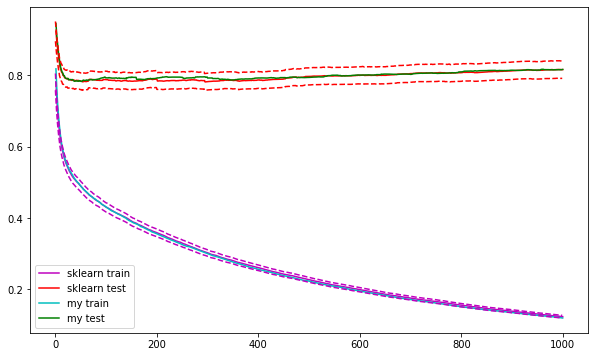

In [166]:
import matplotlib.pyplot as plt
n_est = 1000
base_test_score = np.zeros((n_est,), dtype=np.float64)
for i, y_pred in enumerate(base_model.staged_predict(x_test)):
    base_test_score[i] = base_model.loss_(y_test, y_pred)

plt.figure(figsize=(10, 6))
plt.plot(np.arange(n_est) + 1, base_model.train_score_, 'm-', label='sklearn train')
plt.plot(np.arange(n_est) + 1, base_test_score, 'r-', label='sklearn test')
plt.plot(np.arange(n_est) + 1, my_model.trainerr, 'c-', label='my train')
plt.plot(np.arange(n_est) + 1, my_model.testerr, 'g-', label='my test')
plt.legend()
plt.plot([x * 1.03 for x in base_model.train_score_], 'm-', linestyle='--')
plt.plot([x * 0.97 for x in base_model.train_score_], 'm-', linestyle='--')
plt.plot([x * 1.03 for x in base_test_score], 'r-', linestyle='--')
plt.plot([x * 0.97 for x in base_test_score], 'r-', linestyle='--')
plt.plot()